## Activity: Titanic Survival Predictions Interpretation using Shap Values

In [1]:
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import re
import xgboost

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
train_data = pd.read_csv("train.csv")

# tally missing data
total = train_data.isnull().sum().sort_values(ascending=False)
percent_1 = train_data.isnull().sum()/train_data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['#missing', '%'])
display(missing_data.head(5))

,#missing,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


## Data Preprocessing
Taken from https://github.com/xyonix/shap-values-titanic-xyonix-blog/blob/master/shap_values_titanic_xyonix_blog.ipynb

In [3]:
# form number of family members on board with each passenger
train_data['num_family'] = train_data['SibSp'] + train_data['Parch']    
train_data.drop(columns=['SibSp','Parch'],inplace=True)

# rename some columns
train_data.rename(columns=dict(Pclass='ticket_class', PassengerId='passenger_id'),inplace=True)

In [4]:
# from the Cabin number we can parse the deck level
# level 8 represents a deck level that we could not infer from the Cabin number
# or where the Cabin number was missing
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

train_data['Cabin'] = train_data['Cabin'].fillna("U0")
train_data['deck'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_data['deck'] = train_data['deck'].map(deck)
train_data['deck'] = train_data['deck'].fillna(0)
train_data['deck'] = train_data['deck'].astype(int)

# we can now drop the cabin feature
train_data.drop(columns=['Cabin'], inplace=True)

In [5]:
def impute_age(titanic):

    titanic[titanic==np.inf]=np.nan
    got_age = pd.isnull(titanic['Age']) == False

    titanicWithAge = titanic[got_age]
    titanicWithoutAge = titanic[~got_age]
    variables = ['ticket_class', 'num_family', 'Fare', 'Age','passenger_id']
    one_hot_encoded_embarked = pd.get_dummies(titanicWithAge['Embarked'], prefix='emb')
    one_hot_encoded_sex = pd.get_dummies(titanicWithAge['Sex'])
    titanicWithAge = titanicWithAge[variables]
    titanicWithAge = pd.concat([titanicWithAge, one_hot_encoded_sex, one_hot_encoded_embarked], axis = 1)

    one_hot_encoded_embarked = pd.get_dummies(titanicWithoutAge['Embarked'], prefix='emb')
    one_hot_encoded_sex = pd.get_dummies(titanicWithoutAge['Sex'])
    titanicWithoutAge = titanicWithoutAge[variables]
    titanicWithoutAge = pd.concat([titanicWithoutAge, one_hot_encoded_sex, one_hot_encoded_embarked], axis = 1)

    independentVariables = ['ticket_class', 'female', 'male', 'num_family', 'Fare', 
                            'emb_C', 'emb_Q', 'emb_S']

    rfModel_age = RandomForestRegressor(random_state=100)
    rfModel_age.fit(titanicWithAge[independentVariables], titanicWithAge['Age'])

    generatedAgeValues = rfModel_age.predict(X = titanicWithoutAge[independentVariables])

    titanicWithoutAge['Age'] = generatedAgeValues.astype(int)
    data = pd.concat([titanicWithAge,titanicWithoutAge])
    data = data[['Age','passenger_id','emb_C', 'emb_Q', 'emb_S']]
    data.rename(columns=dict(Age='age'), inplace=True)
    return data

train_imputed_data = train_data.drop(columns='Age').merge(impute_age(train_data), on='passenger_id')
train_imputed_data['age'] = train_imputed_data['age'].astype(int)

In [6]:
# Fare is the price for multiple people in the party.
# Correct by calculating ticket_price per individual.

def price_per_passenger(x):
    return round(x.mean() / len(x), 2)

price_per_passenger_data = train_imputed_data.groupby('Ticket').Fare.agg(price_per_passenger).to_frame().reset_index()
price_per_passenger_data.rename(columns=dict(Fare='ticket_price'), inplace=True)
train_imputed_data = train_imputed_data.merge(price_per_passenger_data, on='Ticket', how='left')
train_imputed_data.drop(columns=['Fare','Ticket'], inplace=True)

In [7]:
# added features with values
genders = {"male": 0, "female": 1}

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

rare_titles = ['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

cols_to_drop = ['Name', 'Embarked','Sex']


np.random.seed(1)


# set gender logical
train_imputed_data['is_female'] = train_imputed_data['Sex'].map(genders)

# extract titles
train_imputed_data['title'] = train_imputed_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# replace titles with a more common title or as Rare
train_imputed_data['title'] = train_imputed_data['title'].replace(rare_titles, 'Rare')
train_imputed_data['title'] = train_imputed_data['title'].replace('Mlle', 'Miss')
train_imputed_data['title'] = train_imputed_data['title'].replace('Ms', 'Miss')
train_imputed_data['title'] = train_imputed_data['title'].replace('Mme', 'Mrs')

# convert titles into numbers
train_imputed_data['title'] = train_imputed_data['title'].map(titles)
# filling NaN with 0, to get safe
train_imputed_data['title'] = train_imputed_data['title'].fillna(0)

# drop columns
train_imputed_data.drop(columns=cols_to_drop, inplace=True)


X_train_data = train_imputed_data.drop(columns=['Survived'])
X_train_data.set_index('passenger_id', inplace=True)
y_train = train_imputed_data['Survived'].values

In [8]:
# display data set with survived feature tacked on
# just for display purposes and interacting with the data
X_train_with_survival_data = X_train_data.copy()
X_train_with_survival_data['survived'] = y_train
display(X_train_with_survival_data)

,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title,survived
passenger_id,,,,,,,,,,,
1,3,1,8,22,False,False,True,7.25,0,1,0
2,1,1,3,38,True,False,False,71.28,1,3,1
3,3,0,8,26,False,False,True,7.92,1,2,1
4,1,1,3,35,False,False,True,26.55,1,3,1
5,3,0,8,35,False,False,True,8.05,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
887,2,0,8,27,False,False,True,13.00,0,5,0
888,1,0,2,19,False,False,True,30.00,1,2,1
889,3,3,8,20,False,False,True,11.72,1,2,0


## Model building and SHAP Generation

Mr,Miss,Mrs,Master,Rare
1,2,3,4,5


passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title
446,1,2,1,4,False,False,True,81.860000,0,4


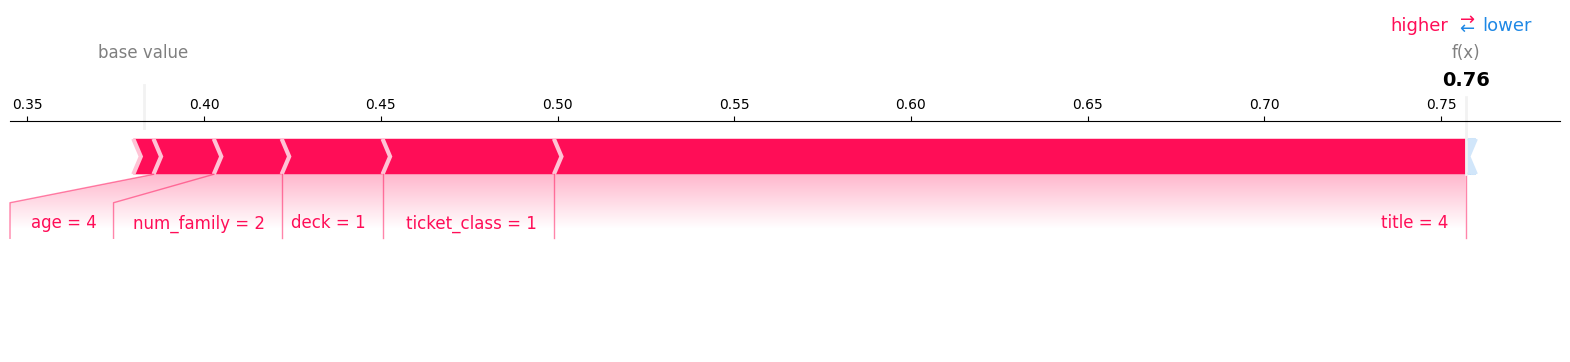

None

passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title
80,3,0,8,30,False,False,True,6.240000,1,2


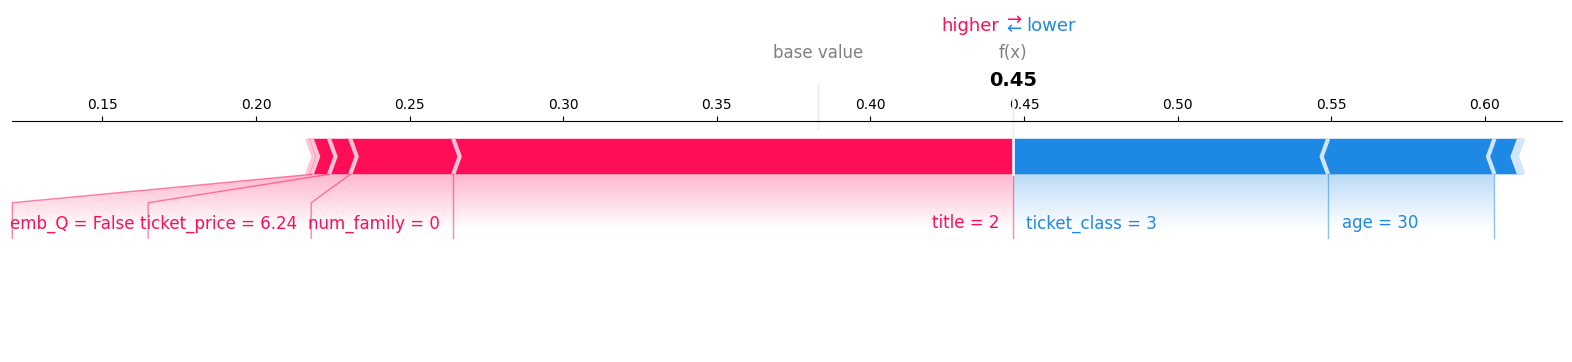

None

passenger_id,ticket_class,num_family,deck,age,emb_C,emb_Q,emb_S,ticket_price,is_female,title
615,3,0,8,35,False,False,True,8.050000,0,1


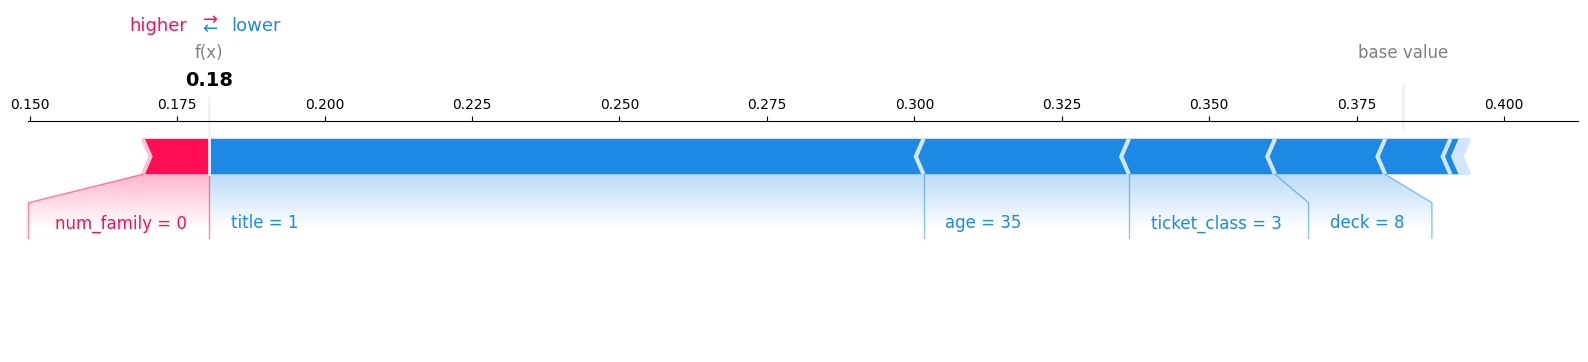

None

In [9]:
# train a model
model = xgboost.train({"learning_rate": 0.01, "seed":100}, 
                      xgboost.DMatrix(X_train_data, label=y_train, enable_categorical=True), 
                      100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_data)

shap_values_df = pd.DataFrame(shap_values)
shap_values_df['passenger_id'] = X_train_data.index.values
shap_values_df.set_index('passenger_id', inplace=True)

# row_sample = np.random.randint(0, len(X_train_data), 3)
pid_sample = [446,  # young and survived
              80,   # model not confident they will survive, 
              615,  # high title
             ]

# display title code for reference since it appears in
# the force plots
display(HTML('<h3 style="color:cornflowerblue">TITLE CODES</h3>'))
display(pd.DataFrame(titles, index=[0]).style.hide())
display(HTML('<h3 style="color:cornflowerblue">SAMPLE SHAP EXPLANATIONS</h3>'))

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
for pid in pid_sample:
    passenger = X_train_data.loc[[pid]]
    passenger_shap_values = shap_values_df.loc[pid].values
    display(passenger.reset_index().style.hide())#.set_table_styles(styles))
    display(shap.force_plot(explainer.expected_value, passenger_shap_values, passenger, matplotlib=True))

In [10]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_data)

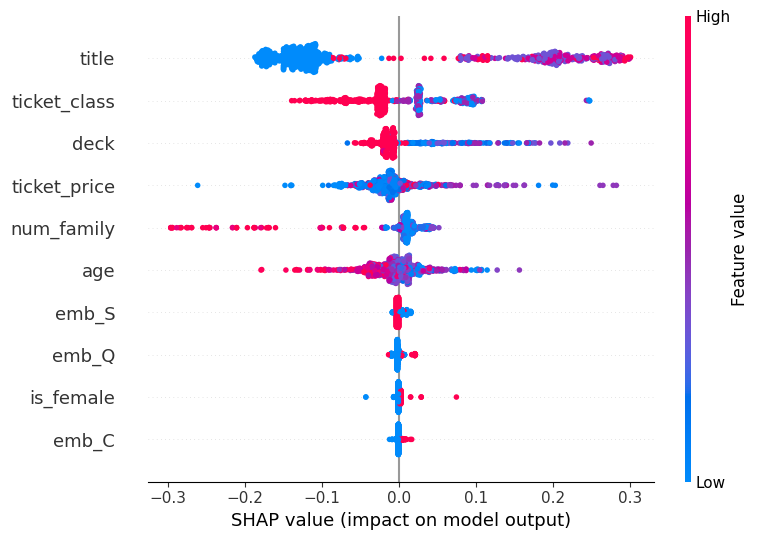

In [11]:
shap.summary_plot(shap_values, X_train_data)


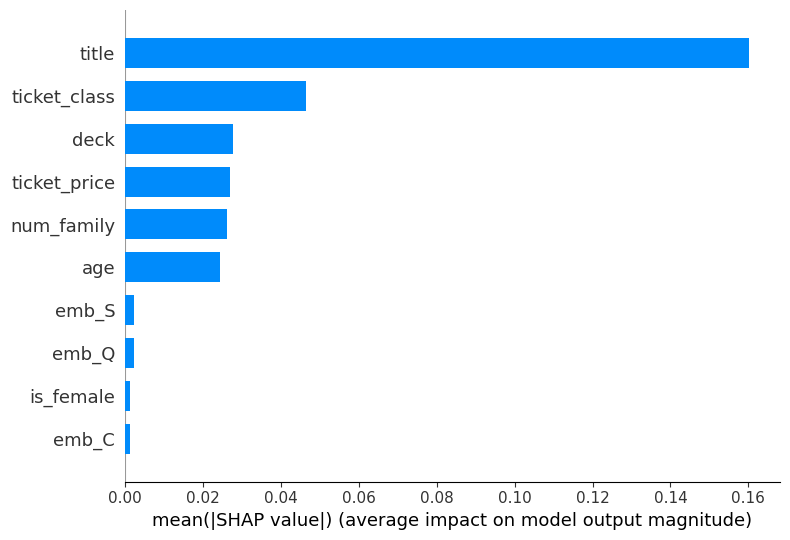

In [12]:
shap.summary_plot(shap_values, X_train_data, plot_type="bar")
